In [1]:
import pandas as pd
import numpy as np
df = pd.read_excel(r'Copy of Extraction PT4 14x59 din 2016 pana in prezent - analysis S1928 (003).xlsx', sheet_name='TL4 -40 Nm' )
dataset = df.values


In [2]:
X = dataset[1:,23:30]
Y = dataset[1:,14]
X = X.astype('float')
Y = Y.astype('float')
print("X:  %s, Y: %s" % (X.shape, Y.shape))
d1 = pd.DataFrame(X)
d2 = pd.DataFrame(Y)
d1.drop([1,3,5], axis=1, inplace=True)
d2.replace(0., np.nan, inplace=True)
d2.replace(-1., np.nan, inplace=True)
d1[7] = d2[0]
d1.dropna(inplace=True)
# d1.isnull().any() # Verifica daca avem vre-o valoare de tip NaN

X = d1.values[0:,:-1]
Y = d1.values[0:, -1:]
X.shape, Y.shape

X:  (918, 7), Y: (918,)


((908, 4), (908, 1))

In [3]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
X_scale = X 
#min_max_scaler.fit_transform(X)
Y_scaler = preprocessing.MinMaxScaler()
Y_scale = Y 
# Y_scaler.fit_transform(Y)

X_scale.shape, Y_scale.shape

((908, 4), (908, 1))

In [4]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X_scale, Y_scale, test_size=0.2)
X_train.shape, Y_train.shape, X_test.shape, Y_test.shape


((726, 4), (726, 1), (182, 4), (182, 1))

In [5]:
import keras
from keras import metrics
from keras import regularizers
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Activation
from keras.layers import Conv2D, MaxPooling2D
from keras.optimizers import Adam, RMSprop
from keras.callbacks import TensorBoard, EarlyStopping, ModelCheckpoint
from keras.utils import plot_model
from keras.models import load_model


def basic_model_3(x_size, y_size):
    t_model = Sequential()
    t_model.add(Dense(80, activation="tanh", kernel_initializer='normal', input_shape=(x_size,)))
    t_model.add(Dropout(0.2))
    t_model.add(Dense(120, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1(0.01), bias_regularizer=regularizers.l1(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(20, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(10, activation="relu", kernel_initializer='normal', 
        kernel_regularizer=regularizers.l1_l2(0.01), bias_regularizer=regularizers.l1_l2(0.01)))
    t_model.add(Dropout(0.1))
    t_model.add(Dense(5, activation="relu", kernel_initializer='normal'))
    t_model.add(Dropout(0.0))
    t_model.add(Dense(y_size))
    t_model.compile(
        loss='mean_squared_error',
        optimizer='nadam',
        metrics=[metrics.mae])
    return(t_model)

model = basic_model_3(4, 1)
model.summary()

Using TensorFlow backend.
W0917 11:32:35.305134 10068 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0917 11:32:35.340102 10068 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0917 11:32:35.343099 10068 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:4115: The name tf.random_normal is deprecated. Please use tf.random.normal instead.

W0917 11:32:35.361100 10068 deprecation_wrapper.py:119] From C:\Users\Alecs\Anaconda3\envs\CChirita\lib\site-packages\keras\backend\tensorflow_backend.py:133: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.p

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 80)                400       
_________________________________________________________________
dropout_1 (Dropout)          (None, 80)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 120)               9720      
_________________________________________________________________
dropout_2 (Dropout)          (None, 120)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2420      
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 10)                210       
__________

In [6]:
epochs = 1000
batch_size = 256

print('Epochs: ', epochs)
print('Batch size: ', batch_size)

keras_callbacks = [
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}-{val_loss:.2f}.hdf5', monitor='val_loss', save_best_only=True, verbose=2)
    # ModelCheckpoint('/tmp/keras_checkpoints/model.{epoch:02d}.hdf5', monitor='val_loss', save_best_only=True, verbose=0)
    # TensorBoard(log_dir='/tmp/keras_logs/model_3', histogram_freq=0, write_graph=True, write_images=True, embeddings_freq=0, embeddings_layer_names=None, embeddings_metadata=None),
    EarlyStopping(monitor='val_mean_absolute_error', patience=20, verbose=0)
]

history = model.fit(X_train, Y_train,
    batch_size=batch_size,
    epochs=epochs,
    shuffle=True,
    verbose=2, # Change it to 2, if wished to observe execution
    validation_data=(X_test, Y_test))
#,
#    callbacks=keras_callbacks)
 

Epochs:  1000
Batch size:  256
Train on 726 samples, validate on 182 samples
Epoch 1/1000
 - 1s - loss: 117.5740 - mean_absolute_error: 9.9864 - val_loss: 114.0992 - val_mean_absolute_error: 9.7324
Epoch 2/1000
 - 0s - loss: 116.7593 - mean_absolute_error: 9.9705 - val_loss: 113.2635 - val_mean_absolute_error: 9.7110
Epoch 3/1000
 - 0s - loss: 115.7787 - mean_absolute_error: 9.9415 - val_loss: 111.8927 - val_mean_absolute_error: 9.6581
Epoch 4/1000
 - 0s - loss: 113.9255 - mean_absolute_error: 9.8633 - val_loss: 108.6799 - val_mean_absolute_error: 9.5008
Epoch 5/1000
 - 0s - loss: 109.1866 - mean_absolute_error: 9.6266 - val_loss: 99.4446 - val_mean_absolute_error: 9.0013
Epoch 6/1000
 - 0s - loss: 94.5635 - mean_absolute_error: 8.8212 - val_loss: 70.9733 - val_mean_absolute_error: 7.3391
Epoch 7/1000
 - 0s - loss: 58.5507 - mean_absolute_error: 6.5301 - val_loss: 28.1502 - val_mean_absolute_error: 4.2061
Epoch 8/1000
 - 0s - loss: 25.0545 - mean_absolute_error: 3.8231 - val_loss: 19.9

Epoch 69/1000
 - 0s - loss: 17.8931 - mean_absolute_error: 3.3029 - val_loss: 16.9927 - val_mean_absolute_error: 3.1706
Epoch 70/1000
 - 0s - loss: 16.5807 - mean_absolute_error: 3.1494 - val_loss: 16.9170 - val_mean_absolute_error: 3.1744
Epoch 71/1000
 - 0s - loss: 17.5349 - mean_absolute_error: 3.2351 - val_loss: 16.9323 - val_mean_absolute_error: 3.1712
Epoch 72/1000
 - 0s - loss: 17.7601 - mean_absolute_error: 3.2794 - val_loss: 16.8783 - val_mean_absolute_error: 3.1745
Epoch 73/1000
 - 0s - loss: 18.5864 - mean_absolute_error: 3.3649 - val_loss: 16.8571 - val_mean_absolute_error: 3.1973
Epoch 74/1000
 - 0s - loss: 17.0910 - mean_absolute_error: 3.1928 - val_loss: 16.9343 - val_mean_absolute_error: 3.2271
Epoch 75/1000
 - 0s - loss: 17.8114 - mean_absolute_error: 3.2740 - val_loss: 17.0335 - val_mean_absolute_error: 3.2464
Epoch 76/1000
 - 0s - loss: 17.2358 - mean_absolute_error: 3.2147 - val_loss: 16.8309 - val_mean_absolute_error: 3.1754
Epoch 77/1000
 - 0s - loss: 17.3725 - me

Epoch 137/1000
 - 0s - loss: 17.2549 - mean_absolute_error: 3.2738 - val_loss: 16.4756 - val_mean_absolute_error: 3.1672
Epoch 138/1000
 - 0s - loss: 16.5742 - mean_absolute_error: 3.2101 - val_loss: 16.4642 - val_mean_absolute_error: 3.1668
Epoch 139/1000
 - 0s - loss: 17.0583 - mean_absolute_error: 3.2553 - val_loss: 16.5298 - val_mean_absolute_error: 3.1646
Epoch 140/1000
 - 0s - loss: 17.4880 - mean_absolute_error: 3.2584 - val_loss: 17.1081 - val_mean_absolute_error: 3.3020
Epoch 141/1000
 - 0s - loss: 16.8522 - mean_absolute_error: 3.2331 - val_loss: 16.4285 - val_mean_absolute_error: 3.1703
Epoch 142/1000
 - 0s - loss: 17.0145 - mean_absolute_error: 3.2259 - val_loss: 16.4843 - val_mean_absolute_error: 3.1635
Epoch 143/1000
 - 0s - loss: 16.6841 - mean_absolute_error: 3.1822 - val_loss: 16.4726 - val_mean_absolute_error: 3.1635
Epoch 144/1000
 - 0s - loss: 17.0667 - mean_absolute_error: 3.2566 - val_loss: 16.6057 - val_mean_absolute_error: 3.1683
Epoch 145/1000
 - 0s - loss: 16.

Epoch 205/1000
 - 0s - loss: 15.9264 - mean_absolute_error: 3.1288 - val_loss: 16.2977 - val_mean_absolute_error: 3.2090
Epoch 206/1000
 - 0s - loss: 16.5335 - mean_absolute_error: 3.1970 - val_loss: 16.2512 - val_mean_absolute_error: 3.1710
Epoch 207/1000
 - 0s - loss: 15.6790 - mean_absolute_error: 3.1069 - val_loss: 16.4078 - val_mean_absolute_error: 3.1692
Epoch 208/1000
 - 0s - loss: 18.0672 - mean_absolute_error: 3.3760 - val_loss: 16.2890 - val_mean_absolute_error: 3.1659
Epoch 209/1000
 - 0s - loss: 16.3302 - mean_absolute_error: 3.1626 - val_loss: 17.1353 - val_mean_absolute_error: 3.3249
Epoch 210/1000
 - 0s - loss: 15.7846 - mean_absolute_error: 3.1280 - val_loss: 16.2540 - val_mean_absolute_error: 3.1963
Epoch 211/1000
 - 0s - loss: 16.0052 - mean_absolute_error: 3.1963 - val_loss: 16.2271 - val_mean_absolute_error: 3.1854
Epoch 212/1000
 - 0s - loss: 16.6784 - mean_absolute_error: 3.1940 - val_loss: 16.2372 - val_mean_absolute_error: 3.1941
Epoch 213/1000
 - 0s - loss: 16.

Epoch 273/1000
 - 0s - loss: 16.5930 - mean_absolute_error: 3.2278 - val_loss: 16.7142 - val_mean_absolute_error: 3.1987
Epoch 274/1000
 - 0s - loss: 17.5523 - mean_absolute_error: 3.3094 - val_loss: 16.8010 - val_mean_absolute_error: 3.3068
Epoch 275/1000
 - 0s - loss: 16.1212 - mean_absolute_error: 3.2060 - val_loss: 16.0903 - val_mean_absolute_error: 3.1681
Epoch 276/1000
 - 0s - loss: 15.6180 - mean_absolute_error: 3.1298 - val_loss: 16.2714 - val_mean_absolute_error: 3.1753
Epoch 277/1000
 - 0s - loss: 16.4103 - mean_absolute_error: 3.1924 - val_loss: 16.0901 - val_mean_absolute_error: 3.2088
Epoch 278/1000
 - 0s - loss: 16.4419 - mean_absolute_error: 3.2389 - val_loss: 16.0395 - val_mean_absolute_error: 3.1867
Epoch 279/1000
 - 0s - loss: 15.9033 - mean_absolute_error: 3.1254 - val_loss: 16.0340 - val_mean_absolute_error: 3.1891
Epoch 280/1000
 - 0s - loss: 15.4719 - mean_absolute_error: 3.1299 - val_loss: 16.2680 - val_mean_absolute_error: 3.1761
Epoch 281/1000
 - 0s - loss: 15.

Epoch 341/1000
 - 0s - loss: 16.1520 - mean_absolute_error: 3.1647 - val_loss: 15.9357 - val_mean_absolute_error: 3.1665
Epoch 342/1000
 - 0s - loss: 15.3063 - mean_absolute_error: 3.1058 - val_loss: 17.6564 - val_mean_absolute_error: 3.4161
Epoch 343/1000
 - 0s - loss: 15.9760 - mean_absolute_error: 3.2049 - val_loss: 16.2943 - val_mean_absolute_error: 3.1817
Epoch 344/1000
 - 0s - loss: 15.8018 - mean_absolute_error: 3.1511 - val_loss: 15.8735 - val_mean_absolute_error: 3.1631
Epoch 345/1000
 - 0s - loss: 15.9978 - mean_absolute_error: 3.1781 - val_loss: 15.8142 - val_mean_absolute_error: 3.1714
Epoch 346/1000
 - 0s - loss: 15.4815 - mean_absolute_error: 3.1522 - val_loss: 15.8728 - val_mean_absolute_error: 3.2031
Epoch 347/1000
 - 0s - loss: 15.8650 - mean_absolute_error: 3.1745 - val_loss: 16.0510 - val_mean_absolute_error: 3.1702
Epoch 348/1000
 - 0s - loss: 16.0856 - mean_absolute_error: 3.1745 - val_loss: 16.6039 - val_mean_absolute_error: 3.3016
Epoch 349/1000
 - 0s - loss: 15.

Epoch 409/1000
 - 0s - loss: 15.3745 - mean_absolute_error: 3.1367 - val_loss: 15.6137 - val_mean_absolute_error: 3.1671
Epoch 410/1000
 - 0s - loss: 15.0149 - mean_absolute_error: 3.0800 - val_loss: 16.0064 - val_mean_absolute_error: 3.1774
Epoch 411/1000
 - 0s - loss: 15.7550 - mean_absolute_error: 3.1683 - val_loss: 15.6667 - val_mean_absolute_error: 3.1621
Epoch 412/1000
 - 0s - loss: 15.2066 - mean_absolute_error: 3.1437 - val_loss: 15.7149 - val_mean_absolute_error: 3.1637
Epoch 413/1000
 - 0s - loss: 15.6170 - mean_absolute_error: 3.1513 - val_loss: 15.9786 - val_mean_absolute_error: 3.2462
Epoch 414/1000
 - 0s - loss: 15.1374 - mean_absolute_error: 3.0836 - val_loss: 15.6923 - val_mean_absolute_error: 3.1987
Epoch 415/1000
 - 0s - loss: 14.8135 - mean_absolute_error: 3.0506 - val_loss: 15.6985 - val_mean_absolute_error: 3.2006
Epoch 416/1000
 - 0s - loss: 15.4062 - mean_absolute_error: 3.1550 - val_loss: 16.2066 - val_mean_absolute_error: 3.1844
Epoch 417/1000
 - 0s - loss: 15.

Epoch 477/1000
 - 0s - loss: 14.6475 - mean_absolute_error: 3.0556 - val_loss: 15.5374 - val_mean_absolute_error: 3.1669
Epoch 478/1000
 - 0s - loss: 15.0755 - mean_absolute_error: 3.1380 - val_loss: 15.6502 - val_mean_absolute_error: 3.1640
Epoch 479/1000
 - 0s - loss: 14.6569 - mean_absolute_error: 3.0511 - val_loss: 15.7597 - val_mean_absolute_error: 3.1697
Epoch 480/1000
 - 0s - loss: 15.5165 - mean_absolute_error: 3.1481 - val_loss: 15.6727 - val_mean_absolute_error: 3.2158
Epoch 481/1000
 - 0s - loss: 14.4716 - mean_absolute_error: 3.0243 - val_loss: 16.0784 - val_mean_absolute_error: 3.1834
Epoch 482/1000
 - 0s - loss: 14.4237 - mean_absolute_error: 2.9970 - val_loss: 15.5890 - val_mean_absolute_error: 3.1612
Epoch 483/1000
 - 0s - loss: 14.5588 - mean_absolute_error: 3.0475 - val_loss: 15.5163 - val_mean_absolute_error: 3.1735
Epoch 484/1000
 - 0s - loss: 14.4355 - mean_absolute_error: 3.0459 - val_loss: 15.6548 - val_mean_absolute_error: 3.1632
Epoch 485/1000
 - 0s - loss: 15.

Epoch 545/1000
 - 0s - loss: 14.2277 - mean_absolute_error: 3.0334 - val_loss: 15.3799 - val_mean_absolute_error: 3.1721
Epoch 546/1000
 - 0s - loss: 14.1846 - mean_absolute_error: 3.0269 - val_loss: 15.4274 - val_mean_absolute_error: 3.1600
Epoch 547/1000
 - 0s - loss: 14.3179 - mean_absolute_error: 3.0452 - val_loss: 15.3909 - val_mean_absolute_error: 3.1725
Epoch 548/1000
 - 0s - loss: 14.2408 - mean_absolute_error: 3.0358 - val_loss: 15.4903 - val_mean_absolute_error: 3.2025
Epoch 549/1000
 - 0s - loss: 14.4416 - mean_absolute_error: 3.0776 - val_loss: 15.4961 - val_mean_absolute_error: 3.2026
Epoch 550/1000
 - 0s - loss: 14.4285 - mean_absolute_error: 3.0578 - val_loss: 15.4193 - val_mean_absolute_error: 3.1766
Epoch 551/1000
 - 0s - loss: 14.8866 - mean_absolute_error: 3.0981 - val_loss: 15.4122 - val_mean_absolute_error: 3.1744
Epoch 552/1000
 - 0s - loss: 14.1558 - mean_absolute_error: 2.9866 - val_loss: 15.4589 - val_mean_absolute_error: 3.1620
Epoch 553/1000
 - 0s - loss: 14.

Epoch 613/1000
 - 0s - loss: 13.9813 - mean_absolute_error: 3.0015 - val_loss: 15.3640 - val_mean_absolute_error: 3.1609
Epoch 614/1000
 - 0s - loss: 13.8175 - mean_absolute_error: 2.9983 - val_loss: 15.3601 - val_mean_absolute_error: 3.1614
Epoch 615/1000
 - 0s - loss: 14.3057 - mean_absolute_error: 3.0490 - val_loss: 15.4063 - val_mean_absolute_error: 3.1620
Epoch 616/1000
 - 0s - loss: 14.1451 - mean_absolute_error: 3.0388 - val_loss: 15.4277 - val_mean_absolute_error: 3.1623
Epoch 617/1000
 - 0s - loss: 14.5577 - mean_absolute_error: 3.1113 - val_loss: 15.3528 - val_mean_absolute_error: 3.1640
Epoch 618/1000
 - 0s - loss: 14.2428 - mean_absolute_error: 3.0349 - val_loss: 15.4079 - val_mean_absolute_error: 3.1629
Epoch 619/1000
 - 0s - loss: 13.5934 - mean_absolute_error: 2.9728 - val_loss: 15.4654 - val_mean_absolute_error: 3.1647
Epoch 620/1000
 - 0s - loss: 14.1538 - mean_absolute_error: 3.0186 - val_loss: 15.3581 - val_mean_absolute_error: 3.1820
Epoch 621/1000
 - 0s - loss: 14.

Epoch 681/1000
 - 0s - loss: 14.2372 - mean_absolute_error: 3.0544 - val_loss: 15.3364 - val_mean_absolute_error: 3.1604
Epoch 682/1000
 - 0s - loss: 14.1466 - mean_absolute_error: 3.0275 - val_loss: 15.3172 - val_mean_absolute_error: 3.1803
Epoch 683/1000
 - 0s - loss: 13.9590 - mean_absolute_error: 3.0076 - val_loss: 15.3503 - val_mean_absolute_error: 3.1600
Epoch 684/1000
 - 0s - loss: 13.9212 - mean_absolute_error: 3.0154 - val_loss: 15.3184 - val_mean_absolute_error: 3.1607
Epoch 685/1000
 - 0s - loss: 13.8858 - mean_absolute_error: 3.0062 - val_loss: 15.3700 - val_mean_absolute_error: 3.1601
Epoch 686/1000
 - 0s - loss: 14.1277 - mean_absolute_error: 3.0338 - val_loss: 15.3127 - val_mean_absolute_error: 3.1599
Epoch 687/1000
 - 0s - loss: 13.4849 - mean_absolute_error: 2.9608 - val_loss: 15.2965 - val_mean_absolute_error: 3.1619
Epoch 688/1000
 - 0s - loss: 13.6174 - mean_absolute_error: 2.9808 - val_loss: 15.2921 - val_mean_absolute_error: 3.1633
Epoch 689/1000
 - 0s - loss: 13.

Epoch 749/1000
 - 0s - loss: 13.4331 - mean_absolute_error: 2.9439 - val_loss: 15.3475 - val_mean_absolute_error: 3.1641
Epoch 750/1000
 - 0s - loss: 13.6872 - mean_absolute_error: 2.9693 - val_loss: 15.2960 - val_mean_absolute_error: 3.1684
Epoch 751/1000
 - 0s - loss: 13.9163 - mean_absolute_error: 3.0311 - val_loss: 15.3026 - val_mean_absolute_error: 3.1660
Epoch 752/1000
 - 0s - loss: 13.8148 - mean_absolute_error: 3.0078 - val_loss: 15.3623 - val_mean_absolute_error: 3.1647
Epoch 753/1000
 - 0s - loss: 14.1172 - mean_absolute_error: 3.0338 - val_loss: 15.2905 - val_mean_absolute_error: 3.1738
Epoch 754/1000
 - 0s - loss: 13.7617 - mean_absolute_error: 3.0109 - val_loss: 15.2899 - val_mean_absolute_error: 3.1687
Epoch 755/1000
 - 0s - loss: 13.8488 - mean_absolute_error: 2.9855 - val_loss: 15.2959 - val_mean_absolute_error: 3.1650
Epoch 756/1000
 - 0s - loss: 13.8928 - mean_absolute_error: 3.0041 - val_loss: 15.3108 - val_mean_absolute_error: 3.1628
Epoch 757/1000
 - 0s - loss: 13.

Epoch 817/1000
 - 0s - loss: 13.3607 - mean_absolute_error: 2.9500 - val_loss: 15.2225 - val_mean_absolute_error: 3.1622
Epoch 818/1000
 - 0s - loss: 13.1560 - mean_absolute_error: 2.9441 - val_loss: 15.2762 - val_mean_absolute_error: 3.1618
Epoch 819/1000
 - 0s - loss: 13.5535 - mean_absolute_error: 2.9914 - val_loss: 15.1969 - val_mean_absolute_error: 3.1732
Epoch 820/1000
 - 0s - loss: 14.2352 - mean_absolute_error: 3.0547 - val_loss: 15.2036 - val_mean_absolute_error: 3.1789
Epoch 821/1000
 - 0s - loss: 13.7140 - mean_absolute_error: 3.0168 - val_loss: 15.1934 - val_mean_absolute_error: 3.1751
Epoch 822/1000
 - 0s - loss: 13.8729 - mean_absolute_error: 2.9927 - val_loss: 15.1916 - val_mean_absolute_error: 3.1717
Epoch 823/1000
 - 0s - loss: 13.5193 - mean_absolute_error: 2.9678 - val_loss: 15.2081 - val_mean_absolute_error: 3.1631
Epoch 824/1000
 - 0s - loss: 13.5861 - mean_absolute_error: 2.9899 - val_loss: 15.2937 - val_mean_absolute_error: 3.1621
Epoch 825/1000
 - 0s - loss: 13.

Epoch 885/1000
 - 0s - loss: 13.7762 - mean_absolute_error: 3.0064 - val_loss: 15.1949 - val_mean_absolute_error: 3.1600
Epoch 886/1000
 - 0s - loss: 13.5248 - mean_absolute_error: 2.9821 - val_loss: 15.1716 - val_mean_absolute_error: 3.1650
Epoch 887/1000
 - 0s - loss: 13.3667 - mean_absolute_error: 2.9747 - val_loss: 15.2025 - val_mean_absolute_error: 3.1605
Epoch 888/1000
 - 0s - loss: 13.5456 - mean_absolute_error: 2.9766 - val_loss: 15.1731 - val_mean_absolute_error: 3.1629
Epoch 889/1000
 - 0s - loss: 13.5811 - mean_absolute_error: 2.9758 - val_loss: 15.2111 - val_mean_absolute_error: 3.1607
Epoch 890/1000
 - 0s - loss: 13.7654 - mean_absolute_error: 3.0121 - val_loss: 15.1870 - val_mean_absolute_error: 3.1613
Epoch 891/1000
 - 0s - loss: 13.6159 - mean_absolute_error: 3.0096 - val_loss: 15.1751 - val_mean_absolute_error: 3.1773
Epoch 892/1000
 - 0s - loss: 13.3608 - mean_absolute_error: 2.9709 - val_loss: 15.1757 - val_mean_absolute_error: 3.1644
Epoch 893/1000
 - 0s - loss: 13.

Epoch 953/1000
 - 0s - loss: 13.1789 - mean_absolute_error: 2.9398 - val_loss: 15.1633 - val_mean_absolute_error: 3.1624
Epoch 954/1000
 - 0s - loss: 13.5840 - mean_absolute_error: 2.9868 - val_loss: 15.1690 - val_mean_absolute_error: 3.1624
Epoch 955/1000
 - 0s - loss: 13.5898 - mean_absolute_error: 2.9939 - val_loss: 15.1656 - val_mean_absolute_error: 3.1621
Epoch 956/1000
 - 0s - loss: 13.4848 - mean_absolute_error: 2.9933 - val_loss: 15.1625 - val_mean_absolute_error: 3.1623
Epoch 957/1000
 - 0s - loss: 13.4153 - mean_absolute_error: 2.9810 - val_loss: 15.1937 - val_mean_absolute_error: 3.1626
Epoch 958/1000
 - 0s - loss: 13.4008 - mean_absolute_error: 2.9691 - val_loss: 15.1416 - val_mean_absolute_error: 3.1640
Epoch 959/1000
 - 0s - loss: 13.6156 - mean_absolute_error: 2.9870 - val_loss: 15.1247 - val_mean_absolute_error: 3.1738
Epoch 960/1000
 - 0s - loss: 13.5691 - mean_absolute_error: 2.9815 - val_loss: 15.1442 - val_mean_absolute_error: 3.1623
Epoch 961/1000
 - 0s - loss: 13.

In [7]:
train_score = model.evaluate(X_train, Y_train, verbose=0)
valid_score = model.evaluate(X_test, Y_test, verbose=0)

print('Train MAE: ', round(train_score[1], 4), ', Train Loss: ', round(train_score[0], 4)) 
print('Val MAE: ', round(valid_score[1], 4), ', Val Loss: ', round(valid_score[0], 4))

Train MAE:  2.9295 , Train Loss:  12.9292
Val MAE:  3.1636 , Val Loss:  15.142


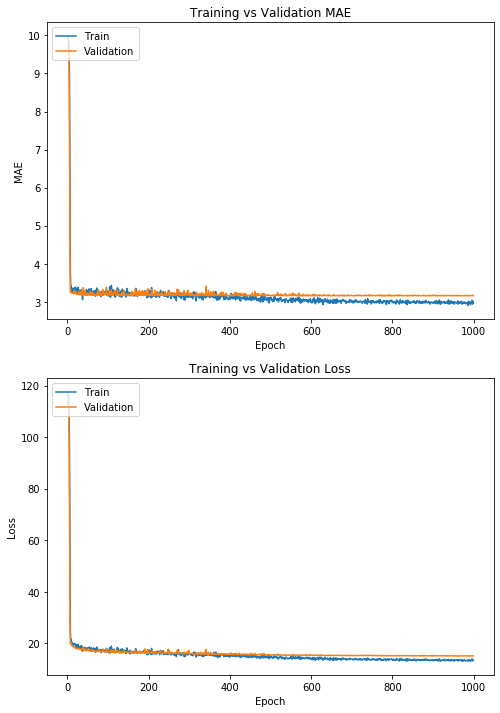

In [10]:
import matplotlib.pyplot as plt
def plot_hist(h, xsize=6, ysize=10):
    # Prepare plotting
    fig_size = plt.rcParams["figure.figsize"]
    plt.rcParams["figure.figsize"] = [xsize, ysize]
    fig, axes = plt.subplots(nrows=4, ncols=4, sharex=True)
    
    # summarize history for MAE
    plt.subplot(211)
    plt.plot(h['mean_absolute_error'])
    plt.plot(h['val_mean_absolute_error'])
    plt.title('Training vs Validation MAE')
    plt.ylabel('MAE')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # summarize history for loss
    plt.subplot(212)
    plt.plot(h['loss'])
    plt.plot(h['val_loss'])
    plt.title('Training vs Validation Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')
    
    # Plot it all in IPython (non-interactive)
    plt.draw()
    plt.show()

    return

p1 = plot_hist(history.history, xsize=8, ysize=12)
plt.show()

In [12]:
emax = 1.
emin = 1.
for i in range(100):
    p = model.predict_on_batch(X_train[i].reshape(1, 4))
    pp = p #Y_scaler.inverse_transform(p)
    py = Y_train[i] #Y_scaler.inverse_transform(Y_train[i].reshape(1,-1))
    r = p/float(Y_train[i])
    if r > emax:
        emax = r
    if r < emin:
        emin = r
    print(pp,py, r)

print(emax, emin)

[[9.745819]] [12.68] [[0.7685977]]
[[9.747476]] [10.7] [[0.91097903]]
[[10.355111]] [9.84] [[1.0523487]]
[[10.25039]] [14.] [[0.7321707]]
[[10.353927]] [13.85] [[0.74757594]]
[[9.253797]] [1.19] [[7.7762995]]
[[10.352494]] [11.] [[0.9411358]]
[[10.354586]] [8.29] [[1.2490454]]
[[9.978229]] [11.61] [[0.85945123]]
[[9.211171]] [13.46] [[0.68433666]]
[[9.74521]] [8.11] [[1.2016289]]
[[9.793267]] [11.] [[0.890297]]
[[10.351552]] [15.] [[0.6901035]]
[[9.266714]] [6.] [[1.5444523]]
[[10.05502]] [7.] [[1.4364315]]
[[9.66607]] [7.68] [[1.2586029]]
[[9.89961]] [8.] [[1.2374512]]
[[8.968395]] [8.52] [[1.0526285]]
[[9.936035]] [15.] [[0.66240233]]
[[10.266941]] [3.] [[3.4223137]]
[[8.970298]] [9.] [[0.99669975]]
[[9.246433]] [7.49] [[1.2345039]]
[[9.745345]] [13.67] [[0.71290016]]
[[9.748971]] [9.46] [[1.0305467]]
[[10.3557]] [15.] [[0.69038]]
[[10.282775]] [17.83] [[0.576712]]
[[10.354512]] [14.] [[0.739608]]
[[10.350663]] [9.34] [[1.1082081]]
[[9.757439]] [9.46] [[1.0314417]]
[[10.355634]] [7.2